# Image Classification X Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet **take weeks on multiple GPUs**. Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture.

<img src="assets/cnnarchitecture.jpg" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but replace the final fully connected layers with our own classifier. This way we can use VGGNet as a feature extractor for our images then easily train a simple classifier on top of that. What we'll do is take the first fully connected layer with 4096 units, including thresholding with ReLUs. We can use those values as a code for each image, then build a classifier on top of those codes.

You can read more about transfer learning from [the CS231n course notes](http://cs231n.github.io/transfer-learning/#tf).

## Pretrained VGGNet


In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'SORRY_THAT_I_CANT_PROVIDE_THE_PRETRAINED_ADDRESS_HERE.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

Parameter file already exists!


## Flower power

Here we'll be using VGGNet to classify images of flowers. To get the flower dataset, run the cell below. This dataset comes from the [TensorFlow inception transfer learning tutorial](https://www.tensorflow.org/tutorials/image_retraining). 

In [2]:
import tarfile

dataset_folder_path = 'flower_photos'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('flower_photos.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Flowers Dataset') as pbar:
        urlretrieve(
            'http://download.tensorflow.org/example_images/flower_photos.tgz',
            'flower_photos.tar.gz',
            pbar.hook)

if not isdir(dataset_folder_path):
    with tarfile.open('flower_photos.tar.gz') as tar:
        tar.extractall()
        tar.close()

## ConvNet Codes

Below, we'll run through all the images in our dataset and get codes for each of them. That is, we'll run the images through the VGGNet convolutional layers and record the values of the first fully connected layer. We can then write these to a file for later when we build our own classifier.

In [3]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [4]:
data_dir = 'flower_photos/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]

In [5]:
batch_size = 32
codes_list = []
labels = []
batch = []

codes = None

with tf.Session() as sess:
    
    # Build the vgg network here
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)

    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            
            img = utils.load_image(os.path.join(class_path, file))
            batch.append(img.reshape((1, 224, 224, 3))) 
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                
                # Image batch to pass to VGG network
                images = np.concatenate(batch)
                
                feed_dict = {input_: images}
                codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

/home/carnd/sai-work/testing/1-transfer-learning/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting dandelion images
32 images processed
64 images processed
96 images processed
128 images processed
160 images processed
192 images processed
224 images processed
256 images processed
288 images processed
320 images processed
352 images processed
384 images processed
416 images processed
448 images processed
480 images processed
512 images processed
544 images processed
576 images processed
608 images processed
640 images processed
672 images processed
704 images processed
736 images processed
768 images processed
800 images processed
832 images processed
864 images processed
896 images processed
898 images processed
Starting roses images
32 images processed
64 images processed
96 images processed
128 images processed
160 images processed
192 images processed
224 images processed
256 images processed
288 images processed
320 images processed
352 

In [6]:
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

## Building the Classifier



In [7]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

### Data prep

As usual, now we need to one-hot encode our labels and create validation/test sets. First up, creating our labels!



In [8]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(labels)

labels_vecs = lb.transform(labels)
print(labels_vecs[0])
print(labels_vecs[1000])
print(labels_vecs[2000]) 

[0 1 0 0 0]
[0 0 1 0 0]
[1 0 0 0 0]


In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

# 0.8 - training data
# 0.2 - Validation and testing data
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
sai_testing = ss.get_n_splits(codes, labels)
print(sai_testing)

train_idx, val_idx = next(ss.split(codes, labels))

half_val_len = int(len(val_idx)/2)
val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]

train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]
test_x, test_y = codes[test_idx], labels_vecs[test_idx]

1


In [10]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)


If you did it right, you should see these sizes for the training sets:

```
Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)
```

### Classifier layers

Once you have the convolutional codes, you just need to build a classfier from some fully connected layers. You use the codes as the inputs and the image labels as targets. Otherwise the classifier is a typical neural network.

In [11]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])

fc = tf.contrib.layers.fully_connected(inputs_, 256)
    
# output layer logits    
logits = tf.contrib.layers.fully_connected(fc, labels_vecs.shape[1], activation_fn=None)
# cross entropy loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy)

# training optimizer
optimizer = tf.train.AdamOptimizer().minimize(cost)

#============================================
# Operations for validation accuracy
predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Batches!

In [12]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:] # Grab all the remaining data
        # I love generators
        yield X, Y

### Training

Here, we'll train the network.

In [21]:
epochs = 10
iteration = 0
saver = tf.train.Saver()
with tf.Session() as sess:
    
    # Training code here
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            feed = {inputs_: x,
                    labels_: y}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Iteration: {}".format(iteration),
                  "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            # 夠5次iteration就睇下Validation 情況係點。
            if iteration % 5 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc))
    
    saver.save(sess, "checkpoints/flowers.ckpt")

Epoch: 1/10 Iteration: 0 Training loss: 8.76977
Epoch: 1/10 Iteration: 1 Training loss: 16.79789
Epoch: 1/10 Iteration: 2 Training loss: 16.06400
Epoch: 1/10 Iteration: 3 Training loss: 9.43594
Epoch: 1/10 Iteration: 4 Training loss: 5.30178
Epoch: 0/10 Iteration: 5 Validation Acc: 0.7084
Epoch: 1/10 Iteration: 5 Training loss: 2.86119
Epoch: 1/10 Iteration: 6 Training loss: 1.26764
Epoch: 1/10 Iteration: 7 Training loss: 2.03230
Epoch: 1/10 Iteration: 8 Training loss: 1.85715
Epoch: 1/10 Iteration: 9 Training loss: 2.60331
Epoch: 0/10 Iteration: 10 Validation Acc: 0.6785
Epoch: 2/10 Iteration: 10 Training loss: 1.20316
Epoch: 2/10 Iteration: 11 Training loss: 1.40339
Epoch: 2/10 Iteration: 12 Training loss: 1.03569
Epoch: 2/10 Iteration: 13 Training loss: 1.04686
Epoch: 2/10 Iteration: 14 Training loss: 0.68544
Epoch: 1/10 Iteration: 15 Validation Acc: 0.8065
Epoch: 2/10 Iteration: 15 Training loss: 0.76203
Epoch: 2/10 Iteration: 16 Training loss: 0.52699
Epoch: 2/10 Iteration: 17 Tra

### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [22]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

Test accuracy: 0.9074


In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

Below, feel free to choose images and see how the trained classifier predicts the flowers in them.

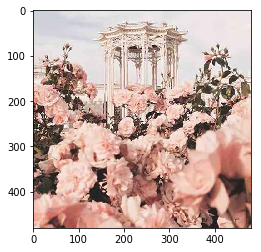

In [24]:
test_img_path = 'flower_photos/sai_testing.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [25]:
# Run this cell if you don't have a vgg graph built
with tf.Session() as sess:
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    vgg = vgg16.Vgg16()
    vgg.build(input_)

/home/carnd/sai-work/testing/1-transfer-learning/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s


In [26]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

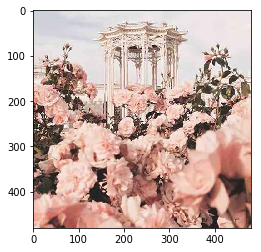

In [27]:
plt.imshow(test_img)

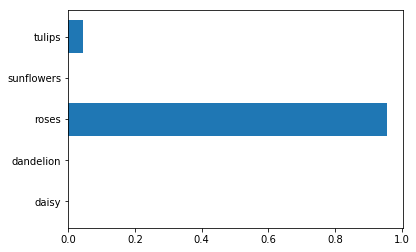

In [28]:
plt.barh(np.arange(5), prediction)
_ = plt.yticks(np.arange(5), lb.classes_)